# RHIRL [1]

In [1]:
import numpy as np
import tensorflow as tf
from rhirl import *

from simple_rl.tasks import NavigationMDP
from simple_rl.agents import QLearningAgent
from simple_rl.planning import ValueIteration
from simple_rl.tasks.grid_world.GridWorldStateClass import GridWorldState

from rhirl_plotting import *
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Experiment 5.1

### Navigation MDP

Defined using simple rl framework [3]

In [2]:
np.random.seed(1)
tf.set_random_seed(0)

goal_reward = 1.
obstacle_reward = -1.
E = 20
nvmdp_test_1 = NavigationMDP(width=E, 
                        height=2,
                        goal_locs=[(E,2)],
                        init_loc=(1,1),
                        # additional_obstacles={2: [(E-3,1), (5,2), (2,2), (2,1)], 3: [(E-2,1)], 4: [(E-1,1)]}, # E=10
                        additional_obstacles={2: [(E-3,1), (6,2), (2,2), (2,1)], 3: [(E-2,1), (8,1)], 4: [(E-1,1)]}, # E=20
                        rand_init=True,
                        cell_types=["empty", "yellow", "red", "green", "purple"],
                        cell_type_rewards=[0, 0, obstacle_reward, obstacle_reward, obstacle_reward],
                        goal_reward=goal_reward,
                        slip_prob=0.00,
                        step_cost=0.2, 
                        vacancy_prob=1.,
                        gamma=.99)

nvmdp_test_2 = NavigationMDP(width=7, 
                        height=7,
                        goal_locs=[(5,5)],
                        init_loc=(1,1),
                        rand_init=True,
                        cell_types=["empty", "yellow", "red", "green", "purple"],
                        cell_type_rewards=[0, 0, obstacle_reward, obstacle_reward, obstacle_reward],
                        goal_reward=goal_reward,
                        slip_prob=0.00,
                        step_cost=0.2, 
                        vacancy_prob=.80,
                        gamma=.99)

nvmdp_orig = NavigationMDP(width=30, 
                        height=30,
                        goal_locs=[(21,21)],
                        init_loc=(1,1),
                        rand_init=True,
                        cell_types=["empty", "yellow", "red", "green", "purple"],
                        cell_type_rewards=[0, 0, obstacle_reward, obstacle_reward, obstacle_reward],
                        goal_reward=goal_reward,
                        slip_prob=0.00,
                        step_cost=0.2, 
                        vacancy_prob=.85,
                        gamma=0.99)

nvmdp = nvmdp_orig
value_iter = ValueIteration(nvmdp, sample_rate=1)
_ = value_iter.run_vi()
v_objective_map = np.zeros((nvmdp.height, nvmdp.width), dtype=np.float32)
for row in range(nvmdp.height):
    for col in range(nvmdp.width):
        x, y = nvmdp._rowcol_to_xy(row, col)
        v_objective_map[row, col] = value_iter.value_func[GridWorldState(x, y)]

### Training Data: 
Set of trajectories D = $\{\tau_0, \tau_1, ..., \tau_N\}$  where  $\tau = [(s_0,a_0), (s_1,a_1), ..., (s_T,a_T)]$

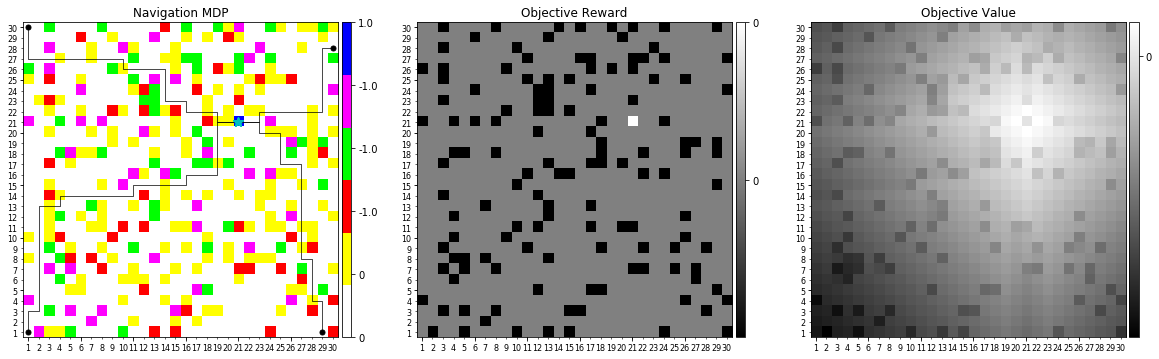

In [3]:
np.random.seed(0)
N_tau = 4 #nvmdp.num_empty_states
D_traj_states, D_traj_actions = nvmdp.sample_data(n_trajectory=N_tau, 
                                                    init_states=[GridWorldState(29,1), GridWorldState(1,30), GridWorldState(1,1), GridWorldState(30,28)], #GridWorldState(1,7)],
                                                    init_repetition=False, 
                                                    policy=value_iter.policy)
plt.figure(figsize=(20,14))
nvmdp.visualize_grid(nvmdp.cells, trajectories=D_traj_states, 
                     subplot_str="131", new_fig=False, show_rewards_cbar=True)
nvmdp.visualize_grid(nvmdp.cell_rewards, trajectories=None, 
                     subplot_str="132", new_fig=False, show_rewards_cbar=True, cmap=plt.cm.gray, title="Objective Reward")
nvmdp.visualize_grid(v_objective_map, trajectories=None, 
                     subplot_str="133", new_fig=False, show_rewards_cbar=True, cmap=plt.cm.gray, title="Objective Value")

## State feature tree (SFT) heap

In [4]:
gamma = 0.99
nA = len(nvmdp.actions)
H = 6

# phi = nvmdp.feature_short_at_state
# phi_loc = nvmdp.feature_short_at_loc
phi = nvmdp.feature_long_at_state
phi_loc = nvmdp.feature_long_at_loc

transition_fn = nvmdp.transition_func
actions = nvmdp.actions
phi_s_dim = len(phi(nvmdp.get_init_state()))

SFT_training, heap_size = get_training_data(D_traj_states, phi, transition_fn, actions, H)
g1, saver = build_rhirl_graph(heap_size, nA, phi_s_dim, gamma, H)
len(g1.get_operations())

436

In [5]:
# This is done to speed up RHC value over full state space
def compute_full_SFT(nvmdp, nA, phi, h):
    SFT_full = {}
    for row in range(nvmdp.height):
        for col in range(nvmdp.width):
            x, y = nvmdp._rowcol_to_xy(row, col)
            state = GridWorldState(x, y)
            SFT_full[state] = get_FLH(state, nA, phi, nvmdp.transition_func, nvmdp.actions, h)[0]
    return SFT_full
SFT_full = compute_full_SFT(nvmdp, nA, phi, H)

### Check gradients
Try to overfit the model by maximizing a Pi(s, a)

### RHIRL training

Model saved in path: /var/tmp/rhirl_model.ckpt
Total: 2888.0457878112793 ms, SFT compute: 6.27743353885887 ms, Epoch time: 722.0096588134766 ms


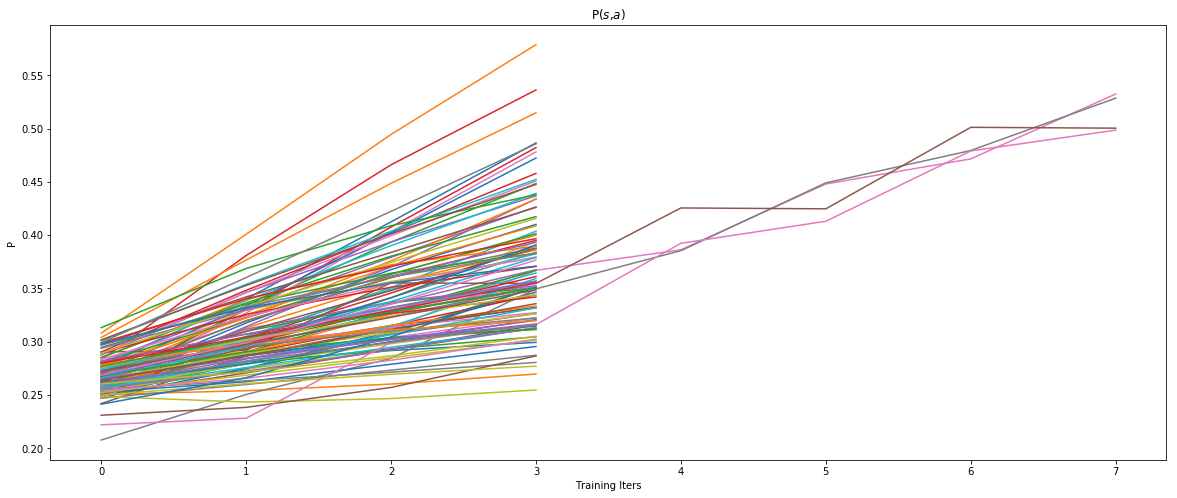

In [6]:
p_vals, w, time_state, time_epoch, time_total, _ = rhirl_train(SFT_training, phi_s_dim, heap_size, nA, D_traj_states, 
                                                            D_traj_actions, g1, saver, n_epochs=4, lr=0.01, verbose=False)
                                                            #run_rhc_callback=lambda w: run_rhc(nvmdp, D_traj_states, D_traj_actions, phi, H, heap_size, w, g1))
print("Total: {} ms, SFT compute: {} ms, Epoch time: {} ms".format(time_total, time_state, time_epoch))
plot_p_vals_all_states(p_vals, D_traj_states, D_traj_actions, legend=False)

## RHC on learned R

In [7]:
rhc_traj_ss_train, rhc_traj_as_train, rhc_behavior_train = run_rhc_train(nvmdp, D_traj_states, D_traj_actions, phi, H, heap_size, w, g1)
rhc_traj_ss_test, rhc_traj_as_test, rhc_behavior_test = run_rhc_test(nvmdp, 30, phi, H, heap_size, w, g1)

In [8]:
"""
The following metric is just for an estimate, but not much useful, things like 
# of obstacles hit, reached goal/not, # steps taken to reach goal/ # optimal steps make more sense
"""
def compute_behavior_err(trajectories, policy, expert_policy, verbose=False, count_repeated_errors=False):
    seen_s = defaultdict(lambda: False)
    n_behaviors = 0
    err = 0
    for i in range(len(trajectories)):
        for j in range(len(trajectories[i])-1):
            s = trajectories[i][j]
            a = policy[s]
            n_behaviors += 1
            expected_a = expert_policy(s)
            
            if a != expected_a and (seen_s[s] is False or count_repeated_errors is True):
                err += 1
                seen_s[s] = True
                if verbose: print("Mistmatch in {}: expert behavior = {}, policy = {}".format(s, expected_a, a))
                    
    return err/float(n_behaviors)
training_behavior_err = compute_behavior_err(rhc_traj_ss_train, rhc_behavior_train, value_iter.policy, verbose=False)
print(training_behavior_err)

0.38461538461538464


In [ ]:
cell_values = compute_cell_values(nvmdp, SFT_full, heap_size, nA, w, g1)
# cell_type_rewards = compute_cell_rewards(nvmdp, w[:5], nvmdp.feature_short_at_loc)
cell_rewards = compute_cell_rewards(nvmdp, w, phi_loc)
print("cell, true, obtained")
list(zip(["empty", "yellow", "red", "green", "purple"],[0, 0, -10, -10, -10], 
            # [round(n,2) for n in np.eye(len(nvmdp.cell_types)).dot(w)[:,0]]))
            [round(n,2) for n in np.hstack((np.eye(len(nvmdp.cell_types)), np.zeros((5,5)))).dot(w)[:,0]]))

In [ ]:
w

In [ ]:
plt.figure(figsize=(20,12))
# cmap=colors.ListedColormap(['white','yellow','red','green','purple', 'blue'])
nvmdp.visualize_grid(nvmdp.cells, trajectories=D_traj_states, 
                     subplot_str="231", new_fig=False, show_rewards_cbar=True)
nvmdp.visualize_grid(nvmdp.cell_rewards, trajectories=None, 
               cmap=plt.cm.gray, subplot_str="232", title="Objective Reward", new_fig=False)
nvmdp.visualize_grid(v_objective_map, trajectories=None, 
               cmap=plt.cm.gray, subplot_str="233", new_fig=False, title="Objective Value")
# nvmdp.visualize_grid(cell_type_rewards, trajectories=None, 
#                cmap=plt.cm.gray, subplot_str="244", new_fig=False, title="RHIRL: Recovered Rewards (only cell type features)")
nvmdp.visualize_grid(cell_rewards, trajectories=None, 
               cmap=plt.cm.gray, subplot_str="234", new_fig=False, title="RHIRL Rewards (h={})".format(H))
nvmdp.visualize_grid(cell_values, trajectories=rhc_traj_ss_train, 
               cmap=plt.cm.gray, subplot_str="235", new_fig=False, title="RHIRL Value")

In [ ]:
plt.figure(figsize=(20,12))
nvmdp.visualize_grid(nvmdp.cells, trajectories=rhc_traj_ss_train, 
                   subplot_str="121", new_fig=False, title="RHC on training states")
nvmdp.visualize_grid(nvmdp.cells, trajectories=rhc_traj_ss_test, 
                   subplot_str="122", new_fig=False, title="RHC on novel states")

## Reference  
[1] MacGlashan, James, and Michael L. Littman. "Between Imitation and Intention Learning." IJCAI. 2015.  
[2] Babes, Monica. Maximum Likelihood Inverse Reinforcement Learning (Doctoral dissertation). 2014.  

## Credits  
- Prof. Michael Littman, Monica Vroman, and Jun Ki Lee  
- ComputeValue() TF implementation is inspired from Ivan Bogatyy's recursive neural network design: https://github.com/bogatyy/cs224d/tree/master/assignment3
- David Abel. Simple RL: "A simple framework for experimenting with Reinforcement Learning in Python." Received from: https://github.com/david-abel/simple_rl.  